In [3]:
import numpy as np
import torch
from utils import mostra_sumario, plota_graficos
import pickle
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

In [2]:
#Verificando se há pastas no diretório de dados sem imagens
import os
count_empty_folders = 0
for id_folder in os.listdir('../MLChallenge_Dataset/Data'):
    id_folder_path = os.path.join('../MLChallenge_Dataset/Data', id_folder)
    if os.path.isdir(id_folder_path):
        for class_folder in os.listdir(id_folder_path):
            class_folder_path = os.path.join(id_folder_path, class_folder)
            if os.path.isdir(class_folder_path): #verify if it is a folder
                if len(os.listdir(class_folder_path)) == 0:
                    count_empty_folders += 1
                    # print('Pasta {} vazia'.format(class_folder_path))
print('Total de pastas vazias: {}'.format(count_empty_folders))

Total de pastas vazias: 4910


## Carregando os dados utilizando o custom Dataset

In [4]:
foldperf = pickle.load(open('output/foldperf.pkl', 'rb'))

foldperf_balanced = pickle.load(open('output/foldperf_balanced.pkl', 'rb'))

### Verificando class imbalance no dataset

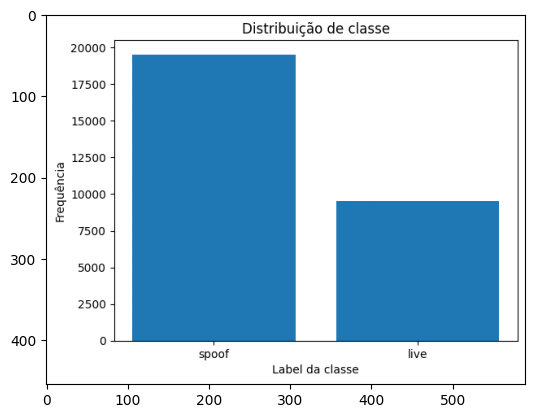

Class ratio: Spoof: 66% - Live: 33%


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('output/data_imbalance.png')
imgplot = plt.imshow(img)
plt.show()
print("Class ratio: Spoof: 66% - Live: 33%")

## Testando o modelo

In [7]:
print(f"Sumário da ResNet sem balanceamento de dados")
mostra_sumario(foldperf)

print("\n==========================================================================================================================\n")

print(f"Sumário da ResNet com balanceamento de dados")
mostra_sumario(foldperf_balanced)

Sumário da ResNet sem balanceamento de dados
Performance do 5 fold cross validation
Average Training Loss: 0.023 	 Average Test Loss: 0.043 	 Average Training Acc: 99.24 	 Average Test Acc: 98.56
Training Precision: 99.239 	 Test Precision: 98.634 	 Training Recall: 99.24 	 Test Recall: 98.56
Training F1: 99.239 	 Test F1: 98.562


Sumário da ResNet com balanceamento de dados
Performance do 5 fold cross validation
Average Training Loss: 0.023 	 Average Test Loss: 0.014 	 Average Training Acc: 99.24 	 Average Test Acc: 99.55
Training Precision: 99.241 	 Test Precision: 99.559 	 Training Recall: 99.24 	 Test Recall: 99.55
Training F1: 99.241 	 Test F1: 99.551


Gráficos da ResNet sem balanceamento de dados


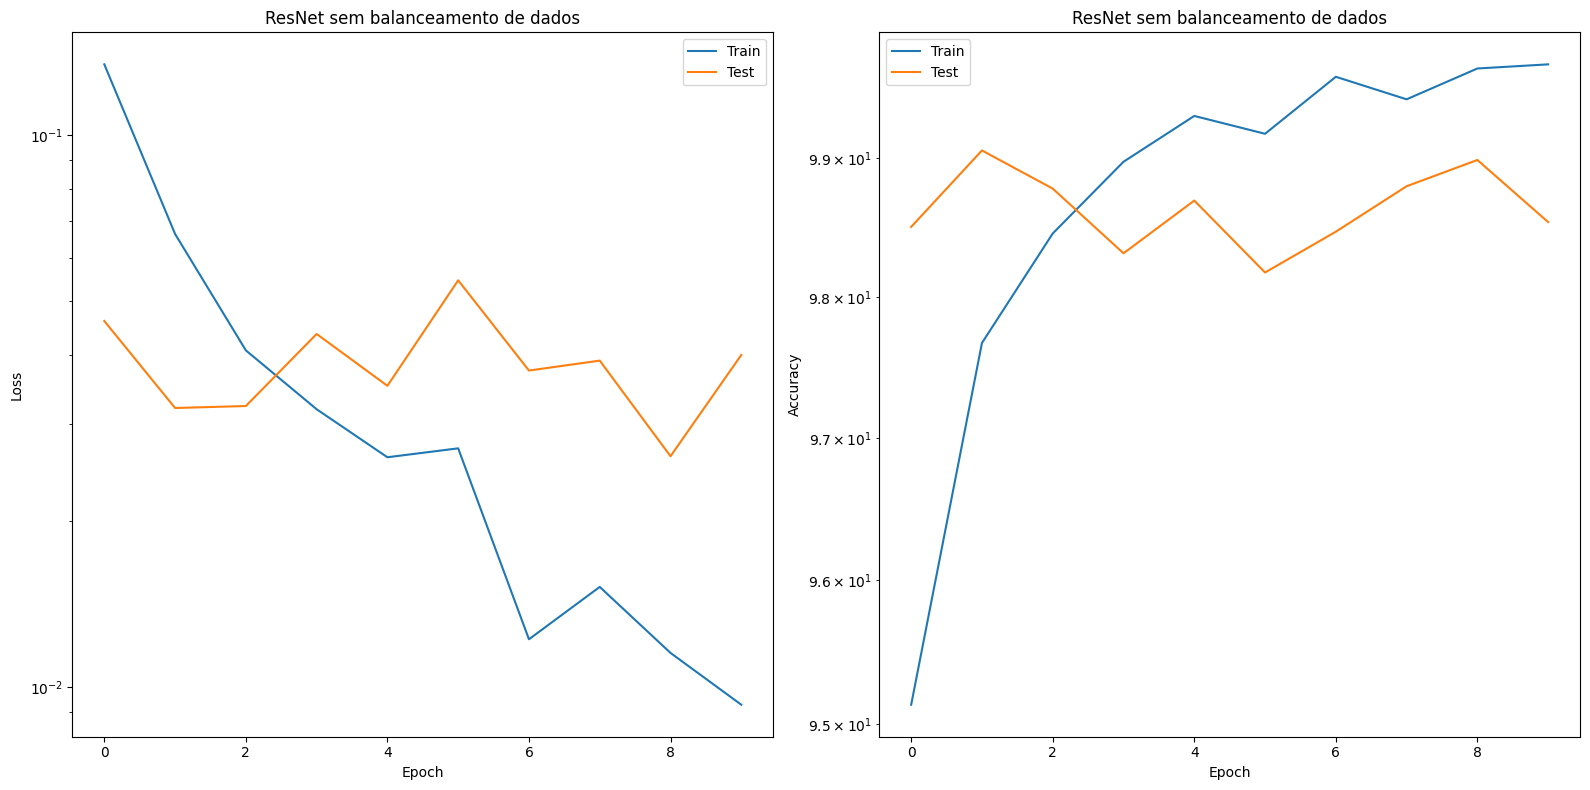



Gráficos da ResNet com balanceamento de dados


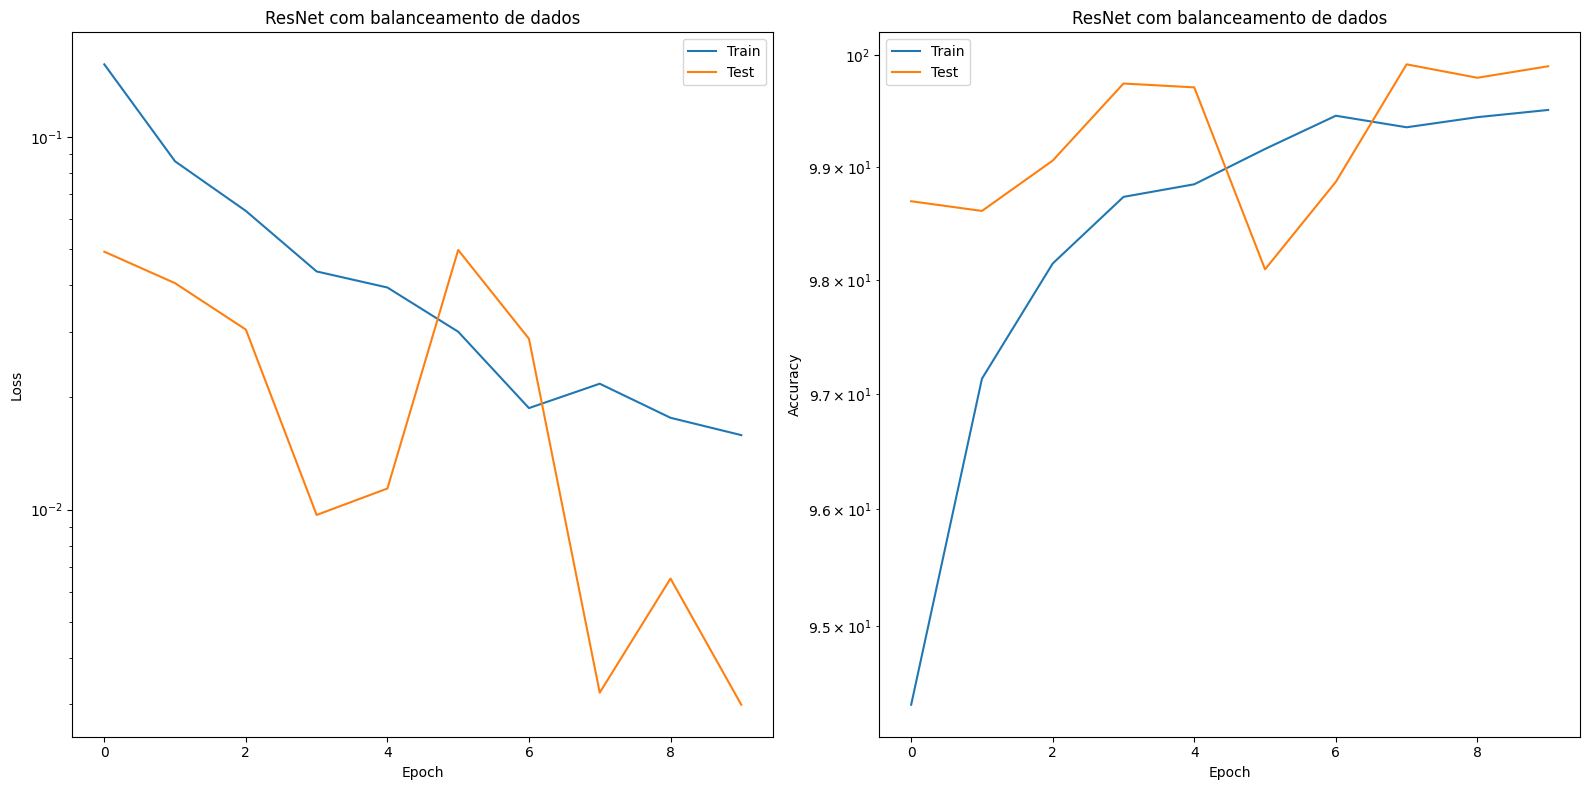

In [9]:
print(f"Gráficos da ResNet sem balanceamento de dados")
plota_graficos(foldperf, title='ResNet sem balanceamento de dados')

print("\n==========================================================================================================================\n")

print(f"Gráficos da ResNet com balanceamento de dados")
plota_graficos(foldperf_balanced, title='ResNet com balanceamento de dados')